In [1]:
import shutil
import glob
import os
import pickle
import matplotlib.pyplot as plt
import cv2
import copy
import json
import numpy as np
import torch
import torchvision

In [2]:
import os
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import OrderedDict
import torch

In [3]:
import clip

In [4]:
# Now find its corresponding names for category id
categories_seen = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    7: 'train',
    8: 'truck',
    9: 'boat',
    15: 'bench',
    16: 'bird',
    19: 'horse',
    20: 'sheep',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    31: 'handbag',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    38: 'kite',
    42: 'surfboard',
    44: 'bottle',
    48: 'fork',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    59: 'pizza',
    60: 'donut',
    62: 'chair',
    65: 'bed',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    90: 'toothbrush',
}

categories_unseen = {
    5: 'airplane',
    6: 'bus',
    17: 'cat',
    18: 'dog',
    21: 'cow',
    22: 'elephant',
    28: 'umbrella',
    28: 'umbrella',
    32: 'tie',
    36: 'snowboard',
    41: 'skateboard',
    47: 'cup',
    49: 'knife',
    61: 'cake',
    63: 'couch',
    76: 'keyboard',
    81: 'sink',
    87: 'scissors',
}

In [5]:
json_path = '/home/uzair.khattak/thesis/OD/Deformable-DETR/data/coco/annotations/instances_val2017.json'

In [6]:
json_file = open(json_path, 'rb')
json_dict = json.load(json_file)

In [7]:
json_dict.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [8]:
json_dict['annotations'][0]

{'segmentation': [[510.66,
   423.01,
   511.72,
   420.03,
   510.45,
   416.0,
   510.34,
   413.02,
   510.77,
   410.26,
   510.77,
   407.5,
   510.34,
   405.16,
   511.51,
   402.83,
   511.41,
   400.49,
   510.24,
   398.16,
   509.39,
   397.31,
   504.61,
   399.22,
   502.17,
   399.64,
   500.89,
   401.66,
   500.47,
   402.08,
   499.09,
   401.87,
   495.79,
   401.98,
   490.59,
   401.77,
   488.79,
   401.77,
   485.39,
   398.58,
   483.9,
   397.31,
   481.56,
   396.35,
   478.48,
   395.93,
   476.68,
   396.03,
   475.4,
   396.77,
   473.92,
   398.79,
   473.28,
   399.96,
   473.49,
   401.87,
   474.56,
   403.47,
   473.07,
   405.59,
   473.39,
   407.71,
   476.68,
   409.41,
   479.23,
   409.73,
   481.56,
   410.69,
   480.4,
   411.85,
   481.35,
   414.93,
   479.86,
   418.65,
   477.32,
   420.03,
   476.04,
   422.58,
   479.02,
   422.58,
   480.29,
   423.01,
   483.79,
   419.93,
   486.66,
   416.21,
   490.06,
   415.57,
   492.18,
   416.85,

In [9]:
# So simple steps
# Choose an image
# Parse through annotations to gather all of its annotations
# Along side with its category id
# Once we have this info, we will use CLIP for classification
# with different context (bbox proportions)
# some good chioces: 85576,88265,97988,101780,101787
# positive examples: for only category name :521141
# positive examples: for complete sentence : 88951 (dog)
image_id_choosen = 106881 # 000000 000000
all_GT_boxes_for_given_image_RPN = []
all_GT_boxes_for_given_image_CLIP = []
category_id_list = []
for single_annotation_file in json_dict['annotations']:
    # Check the image_id if it is matching or not
    id = single_annotation_file['image_id']
    if id == image_id_choosen:
        print('annotation found')
        # Meaning one box has been found for this image
        # First preprocess each box in format required by RPN
        bbox = single_annotation_file['bbox']
        # Convert to x1,y1 (top left) x2,y2 (bottom right) notation
        # from X,Y (top left), W, H
        x1, y1, x2, y2 = bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]
        bbox = [x1, y1, x2, y2]
        all_GT_boxes_for_given_image_RPN.append(bbox)
        # For CLIP save original annotations w.r.t raw image ie XYWH
        all_GT_boxes_for_given_image_CLIP.append(single_annotation_file['bbox'])
        category_id_list.append(single_annotation_file['category_id'])

annotation found


In [10]:
all_GT_boxes_for_given_image_CLIP # X,Y W, H Format

[[208.17, 239.96, 64.05, 160.13]]

In [11]:
category_id_list

[16]

In [12]:
# Now use only those categories which are from base and novel
category_names = []
all_GT_boxes = []
all_GT_xywh = []
for index, single_category_id in enumerate(category_id_list):
    if single_category_id in categories_seen.keys():
        all_GT_boxes.append(all_GT_boxes_for_given_image_RPN[index])
        all_GT_xywh.append(all_GT_boxes_for_given_image_CLIP[index])
        category_names.append(categories_seen[single_category_id])
    elif single_category_id in categories_unseen.keys():
        category_names.append(categories_unseen[single_category_id])
        all_GT_boxes.append(all_GT_boxes_for_given_image_RPN[index])
        all_GT_xywh.append(all_GT_boxes_for_given_image_CLIP[index])
        

In [13]:
print(category_names)
all_GT_boxes

['bird']


[[208.17, 239.96, 272.21999999999997, 400.09000000000003]]

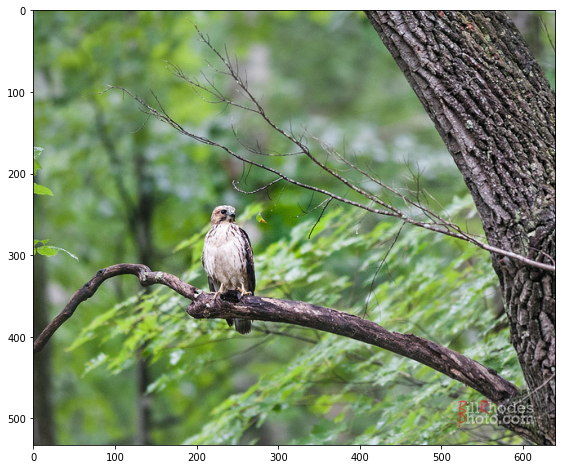

In [15]:
# Now plot GT bounding boxes on the image
# Load image
image_id_str = str(image_id_choosen).zfill(12)
path = 'val2017/'
image = plt.imread(path + image_id_str + '.jpg')
plt.figure(figsize=(10,8))
plt.imshow(image)
# frame = cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color, 5)

In [1441]:
category_names

['bird']

In [16]:
annotation_index = 0
color = (0, 255, 0)
# We will visualize above index annotation on the image
bbox_xywh = all_GT_xywh[annotation_index]
bbox = all_GT_boxes[annotation_index]
bbox

[208.17, 239.96, 272.21999999999997, 400.09000000000003]

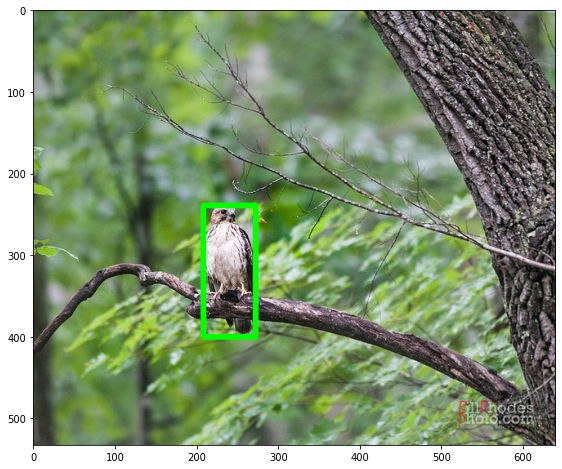

In [1443]:
frame = cv2.rectangle(copy.copy(image), (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color, 5)
plt.figure(figsize=(10,8))
plt.imshow(frame)

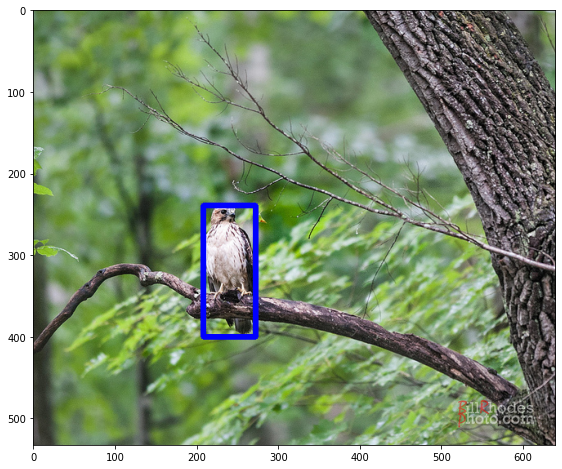

In [17]:
# Now lets vary the context of the ground truth box
# Will use the same code of Hanoona
## set and crop the ROI 
x,y,w,h = bbox_xywh
plt.figure(figsize=(10,8))
i = cv2.rectangle(copy.copy(image), (int(x),int(y)), (int(x+w),int(y+h)), (0,0,255), 5)
plt.imshow(i)

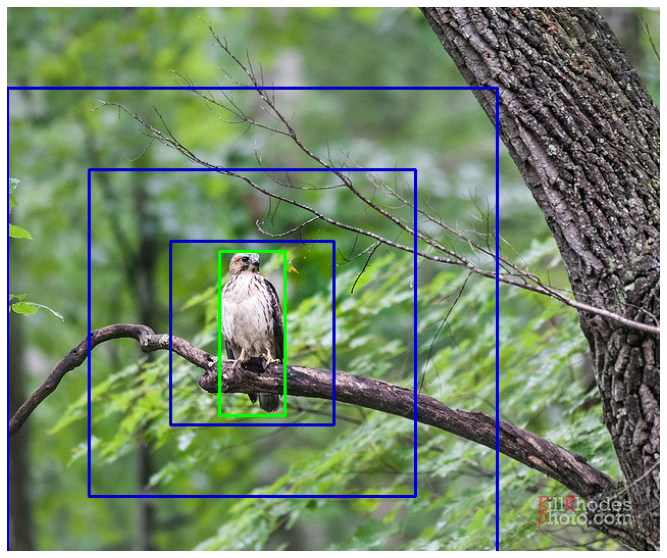

In [25]:
## get the center and the radius
cx = x+w//2
cy = y+h//2
cr  = max(w,h)//2 
## set offset, repeat enlarger ROI
db = (0, 102, 204)
db = (0, 0, 204)
dr = 80
im = copy.copy(image)
im = cv2.rectangle(copy.copy(image), (int(x),int(y)), (int(x+w),int(y+h)), (0,255,0), 2)
bboxes_different_ctx = []
cropped_images = []
# save first cropped bounding box
# colors = [(
cropped_images.append(image[int(bbox_xywh[1]): int(bbox_xywh[1]) + int(bbox_xywh[3]), int(bbox_xywh[0]): int(bbox_xywh[0]) + int(bbox_xywh[2])])
for i in range(0,3):
    if i == 0:
        r = cr+i*dr
        im = cv2.rectangle(im, (int(cx-r), int(cy-r)-10), (int(cx+r), int(cy+r)+10), db, 2)
        # Also save all bounding boxes 
        bboxes_different_ctx.append([int(cx-r), int(cy-r), int(cx+r), int(cy+r)]) # XYXY notatation
        croped = image[int(cy-r):int(cy+r)-10, int(cx-r):int(cx+r)+10]
        cropped_images.append(croped)
    else:
        r = cr+i*dr
        im = cv2.rectangle(im, (int(cx-r), int(cy-r)), (int(cx+r), int(cy+r)), db, 2)
        # Also save all bounding boxes 
        bboxes_different_ctx.append([int(cx-r), int(cy-r), int(cx+r), int(cy+r)]) # XYXY notatation
        croped = image[int(cy-r):int(cy+r), int(cx-r):int(cx+r)]
        cropped_images.append(croped)  
    # also add complete image
# cropped_images.append(image) 
plt.figure(figsize=(12,10))
plt.axis("off")
plt.imshow(im)
plt.savefig("eagle_reduced_thickness.png")
plt.show()

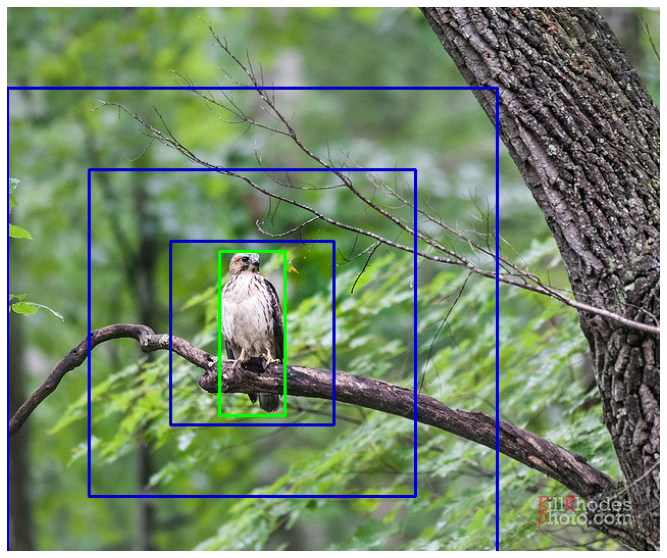

[[160, 239, 320, 399], [80, 159, 400, 479], [0, 79, 480, 559]]

In [35]:
# import pyshine as ps
## get the center and the radius
cx = x+w//2
cy = y+h//2
cr  = max(w,h)//2 
## set offset, repeat enlarger ROI
db = (0, 102, 204)
db = (0, 0, 204)
dr = 80
im = copy.copy(image)
im = cv2.rectangle(copy.copy(image), (int(x),int(y)), (int(x+w),int(y+h)), (0,255,0), 2)
bboxes_different_ctx = []
cropped_images = []
# save first cropped bounding box
# colors = [(
cropped_images.append(image[int(bbox_xywh[1]): int(bbox_xywh[1]) + int(bbox_xywh[3]), int(bbox_xywh[0]): int(bbox_xywh[0]) + int(bbox_xywh[2])])
for i in range(0,3):
    if i == 0:
        r = cr+i*dr
        im = cv2.rectangle(im, (int(cx-r), int(cy-r)-10), (int(cx+r), int(cy+r)+10), db, 2)
        # Also save all bounding boxes 
        bboxes_different_ctx.append([int(cx-r), int(cy-r), int(cx+r), int(cy+r)]) # XYXY notatation
        croped = image[int(cy-r):int(cy+r)-10, int(cx-r):int(cx+r)+10]
        cropped_images.append(croped)
    else:
        r = cr+i*dr
        im = cv2.rectangle(im, (int(cx-r), int(cy-r)), (int(cx+r), int(cy+r)), db, 2)
        # Also save all bounding boxes 
        bboxes_different_ctx.append([int(cx-r), int(cy-r), int(cx+r), int(cy+r)]) # XYXY notatation
        croped = image[int(cy-r):int(cy+r), int(cx-r):int(cx+r)]
        cropped_images.append(croped)  
    # also add complete image
# cropped_images.append(image) 
plt.figure(figsize=(12,10))
plt.axis("off")
plt.imshow(im)
plt.savefig("eagle_reduced_thickness.png")
plt.show()
bboxes_different_ctx

0 nm
3 nm


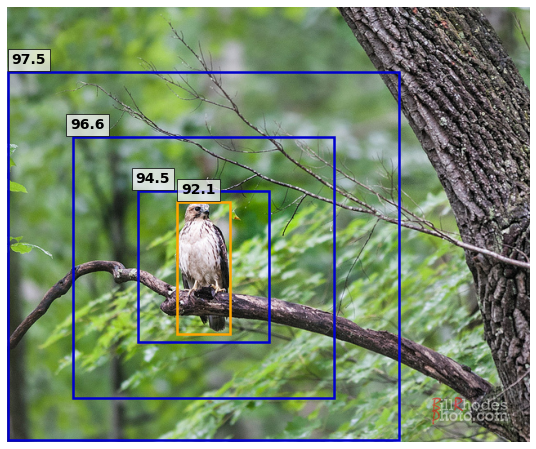

In [140]:
image_id_str = str(image_id_choosen).zfill(12)
path = 'val2017/'
im = Image.open(path + image_id_str + '.jpg')
kept = [0.9, 0.9, 0.9,  0.9]
bboxes = [[208, 239, 272, 400],[160, 225, 320, 410], [80, 159, 400, 479], [0, 79, 480, 530]]
lab = ['92.1', '94.5', '96.6', '97.5']
plot_results(im, kept, bboxes, lab)
plt.savefig('fig_intro_zs_clip.png', bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

In [128]:
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
def plot_results(pil_img, scores, boxes, labels, save=None, masks=None):
    plt.figure(figsize=(12, 8))
    np_image = np.array(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if masks is None:
      masks = [None for _ in range(len(scores))]
    # print(len(scores), len(boxes), len(labels), len(masks))
    assert len(scores) == len(boxes) == len(labels) == len(masks)
    i = 0
    cs = ['orange', 'mediumblue', 'mediumblue', 'mediumblue']
    for s, (xmin, ymin, xmax, ymax), l, mask, c in zip(scores, boxes, labels, masks, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=cs[i], linewidth=2.5))
        
        # print(l)
#         # text = f'{l}: {s:0.2f}'
        text = f'{l}'
        # text = text.split()[1]
        
        if i>2 or i==0:
            ax.text(xmin+5, ymin-10, text, fontsize=14, weight="bold", bbox=dict(facecolor='white', alpha=0.7))
            print(i, "nm")
        else:
            ax.text(xmin-3, ymin-10, text, fontsize=14, weight="bold", bbox=dict(facecolor='white', alpha=0.7))
        i += 1
        if mask is None:
          continue
        np_image = apply_mask(np_image, mask, c)

        padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
          # Subtract the padding and flip (y, x) to (x, y)
          verts = np.fliplr(verts) - 1
          p = Polygon(verts, facecolor="none", edgecolor=c)
          ax.add_patch(p)

    plt.axis('off')
    plt.imshow(np_image)
    
    if save is not None:
        plt.savefig(save)
        

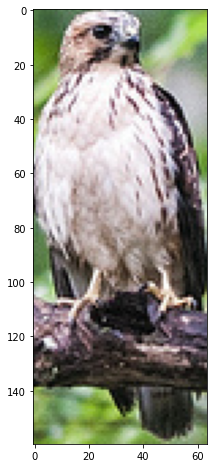

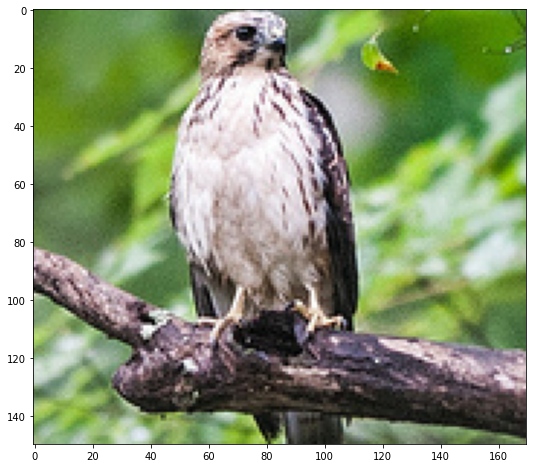

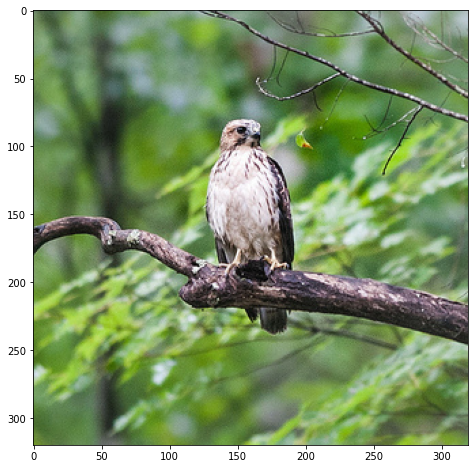

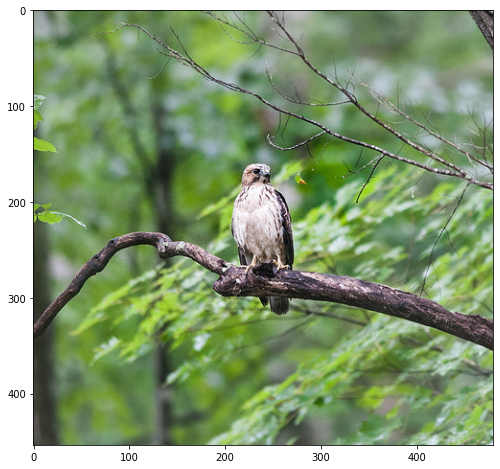

In [1391]:
# Now lets visualize all cropped images
for single_crop in cropped_images:
    plt.figure(figsize=(10,8))
    plt.imshow(single_crop)
    plt.show()

In [1392]:
# Instead of making bboxes with some formula, manually design a box, which really shows the context

In [1393]:
# annotation_index = 0 # which annotation to plot on image
color = (0, 255, 0)
# We will visualize above index annotation on the image
bbox_xywh = all_GT_xywh[annotation_index]
bbox = all_GT_boxes[annotation_index]
print('xyxy ',bbox)
print('xywh', bbox_xywh)


xyxy  [208.17, 239.96, 272.21999999999997, 400.09000000000003]
xywh [208.17, 239.96, 64.05, 160.13]


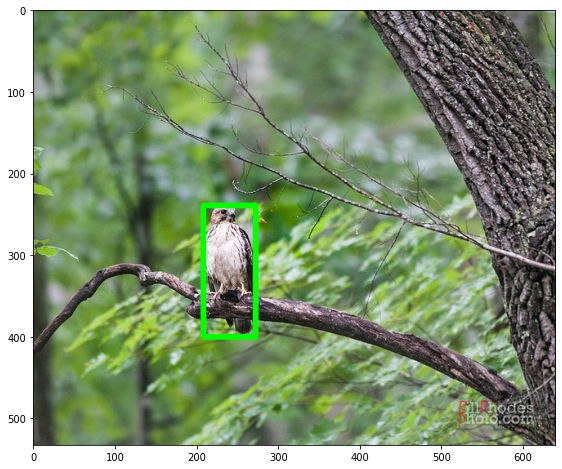

In [1394]:
frame = cv2.rectangle(copy.copy(image), (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color, 5)
plt.figure(figsize=(10,8))
plt.imshow(frame)

In [1395]:
# Now make a custom new bbox, that captures more context
# Try to expand it from top left, and bottom part of box remains same
expand_x = 100
expand_y = 100
x, y, w, h = bbox_xywh
x_new = x - expand_x
y_new = y - expand_y
new_width = w + expand_x
new_height = h + expand_y
bbox_new = [x_new, y_new, new_width, new_height]
print(bbox_xywh)
print(bbox_new)
# Convert it into XYXY for plotting
bbox_xyxy = bbox_new[0], bbox_new[1], bbox_new[0] + bbox_new[2], bbox_new[1] + bbox_new[3]

[208.17, 239.96, 64.05, 160.13]
[108.16999999999999, 139.96, 164.05, 260.13]


In [1396]:
# Now make a custom new bbox, that captures more context
# Try to expand it from top right, and bottom part of box remains same
expand_x = 100
expand_y = 100
x, y, w, h = bbox_xywh
x = x + w
x_new = x + expand_x 
y_new = y - expand_y
new_width = w + 2*expand_x
new_height = h + expand_y
x_new = x_new - new_width + expand_x
bbox_new = [x_new, y_new, new_width, new_height]
print(bbox_xywh)
print(bbox_new)
# Convert it into XYXY for plotting
bbox_xyxy = bbox_new[0], bbox_new[1], bbox_new[0] + bbox_new[2], bbox_new[1] + bbox_new[3]

[208.17, 239.96, 64.05, 160.13]
[208.16999999999996, 139.96, 264.05, 260.13]


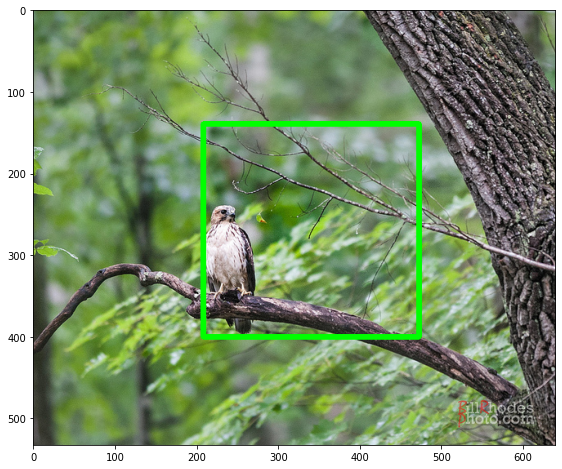

In [1397]:
frame = cv2.rectangle(copy.copy(image), (int(bbox_xyxy[0]), int(bbox_xyxy[1])), (int(bbox_xyxy[2]), int(bbox_xyxy[3])), color, 5)
plt.figure(figsize=(10,8))
plt.imshow(frame)

In [1398]:
# Lets make those manual crops
manual_crops = [cropped_images[0]]
manual_crops.append(image[int(bbox_xyxy[1]): int(bbox_xyxy[1]) + int(bbox_xyxy[3]), int(bbox_xyxy[0]): int(bbox_xyxy[0]) + int(bbox_xyxy[2])])

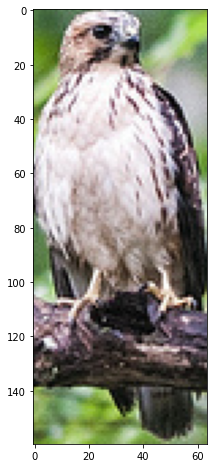

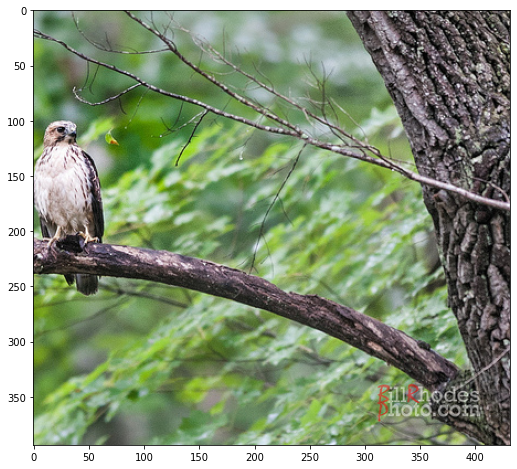

In [1399]:
# Show cropped images
# Now lets visualize all cropped images
for single_crop in manual_crops:
    plt.figure(figsize=(10,8))
    plt.imshow(single_crop)
    plt.show()

In [1400]:
# Now lets pass all through CLIP
# for text embeddings, lets use all classes of COCO
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

In [1401]:
print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [1402]:
# First prepare the text embeddings
only_names = [categories_seen[name] for name in categories_seen.keys()]
only_names = only_names + [categories_unseen[name] for name in categories_unseen.keys()]
all_text_names = ['a photo of a ' + categories_seen[name] for name in categories_seen.keys()]
all_text_names = all_text_names + [ 'a photo of a ' +  categories_unseen[name]  for name in categories_unseen.keys()]

In [1403]:
# # First prepare the text embeddings
# only_names = [categories_seen[name] for name in categories_seen.keys()]
# only_names = only_names + [categories_unseen[name]  for name in categories_unseen.keys()]
# all_text_names = ['a photo of a ' + categories_seen[name] + ' in the scene' for name in categories_seen.keys()]
# all_text_names = all_text_names + [ 'a photo of a ' +  categories_unseen[name] + ' in the scene' for name in categories_unseen.keys()]


In [1404]:
len(all_text_names)

65

In [1405]:
all_text_names

['a photo of a person',
 'a photo of a bicycle',
 'a photo of a car',
 'a photo of a motorcycle',
 'a photo of a train',
 'a photo of a truck',
 'a photo of a boat',
 'a photo of a bench',
 'a photo of a bird',
 'a photo of a horse',
 'a photo of a sheep',
 'a photo of a bear',
 'a photo of a zebra',
 'a photo of a giraffe',
 'a photo of a backpack',
 'a photo of a handbag',
 'a photo of a suitcase',
 'a photo of a frisbee',
 'a photo of a skis',
 'a photo of a kite',
 'a photo of a surfboard',
 'a photo of a bottle',
 'a photo of a fork',
 'a photo of a spoon',
 'a photo of a bowl',
 'a photo of a banana',
 'a photo of a apple',
 'a photo of a sandwich',
 'a photo of a orange',
 'a photo of a broccoli',
 'a photo of a carrot',
 'a photo of a pizza',
 'a photo of a donut',
 'a photo of a chair',
 'a photo of a bed',
 'a photo of a toilet',
 'a photo of a tv',
 'a photo of a laptop',
 'a photo of a mouse',
 'a photo of a remote',
 'a photo of a microwave',
 'a photo of a oven',
 'a phot

In [1406]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f5946c75ca0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [1407]:
images = []
for crop in manual_crops:
    images.append(preprocess(Image.fromarray(crop)))
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(all_text_names).cuda()

In [1408]:
images[0].shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


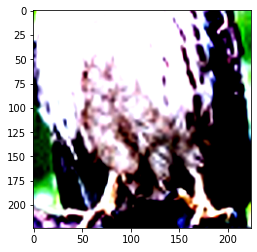

In [1409]:
plt.imshow(images[0].permute(1,2,0).cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


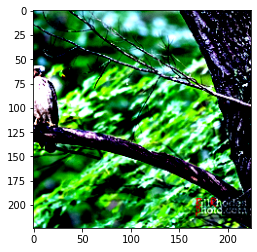

In [1410]:
plt.imshow(images[1].permute(1,2,0).cpu())

In [1411]:
# Now lets classify it
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [1412]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

In [1413]:
# now doing the classification
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

In [1414]:
top_labels

tensor([[ 8, 55,  0, 19, 10],
        [ 8, 19, 13, 12, 38]])

In [1415]:
text_features.shape

torch.Size([65, 512])

In [1416]:
all_text_names[35]

'a photo of a toilet'

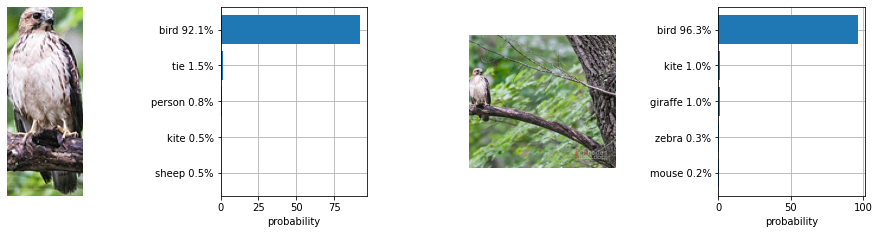

In [1417]:
# plt.figure(figsize=(16, 16))

# for i, image in enumerate(manual_crops):
#     plt.subplot(4, 4, 2 * i + 1)
#     plt.imshow(image)
#     plt.axis("off")

#     plt.subplot(4, 4, 2 * i + 2)
#     y = np.arange(top_probs.shape[-1])
#     plt.grid()
#     plt.barh(y, top_probs[i])
#     plt.gca().invert_yaxis()
#     plt.gca().set_axisbelow(True)
#     plt.yticks(y, [only_names[index] for index in top_labels[i].numpy()])
#     plt.xlabel("probability")

# plt.subplots_adjust(wspace=0.5)
# plt.show()
# print(top_probs)
plt.figure(figsize=(16, 16))

for i, image in enumerate(manual_crops):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i]*100)
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [(only_names[index] + ' ' + str("{:.1f}".format(top_probs[i][idx].item()*100)) + '%') \
                   for idx,index in enumerate(top_labels[i].numpy())])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.7)
plt.show()
# print(top_probs)

In [1418]:
# Also lets do this on sequencial cropped images
images = []
for crop in cropped_images:
    images.append(preprocess(Image.fromarray(crop)))
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(all_text_names).cuda()
all_text_names

['a photo of a person',
 'a photo of a bicycle',
 'a photo of a car',
 'a photo of a motorcycle',
 'a photo of a train',
 'a photo of a truck',
 'a photo of a boat',
 'a photo of a bench',
 'a photo of a bird',
 'a photo of a horse',
 'a photo of a sheep',
 'a photo of a bear',
 'a photo of a zebra',
 'a photo of a giraffe',
 'a photo of a backpack',
 'a photo of a handbag',
 'a photo of a suitcase',
 'a photo of a frisbee',
 'a photo of a skis',
 'a photo of a kite',
 'a photo of a surfboard',
 'a photo of a bottle',
 'a photo of a fork',
 'a photo of a spoon',
 'a photo of a bowl',
 'a photo of a banana',
 'a photo of a apple',
 'a photo of a sandwich',
 'a photo of a orange',
 'a photo of a broccoli',
 'a photo of a carrot',
 'a photo of a pizza',
 'a photo of a donut',
 'a photo of a chair',
 'a photo of a bed',
 'a photo of a toilet',
 'a photo of a tv',
 'a photo of a laptop',
 'a photo of a mouse',
 'a photo of a remote',
 'a photo of a microwave',
 'a photo of a oven',
 'a phot

In [1419]:
images[0].shape

torch.Size([3, 224, 224])

In [1420]:
# Now lets classify it
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [1421]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

In [1422]:
# now doing the classification
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

In [1423]:
top_labels

tensor([[ 8, 55,  0, 19, 10],
        [ 8, 19,  0, 55, 39],
        [ 8, 19, 13, 55,  0],
        [ 8, 19, 13,  0, 55]])

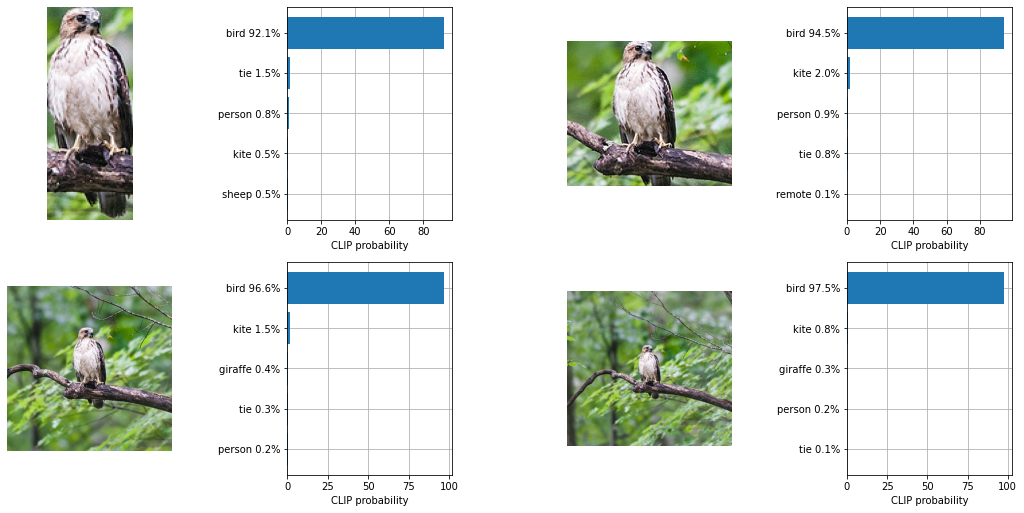

In [1454]:
plt.figure(figsize=(18, 18))

for i, image in enumerate(cropped_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i]*100)
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [(only_names[index] + ' ' + str("{:.1f}".format(top_probs[i][idx].item()*100)) + '%') \
                   for idx,index in enumerate(top_labels[i].numpy())])
    plt.xlabel("CLIP probability")

plt.subplots_adjust(wspace=0.7)
plt.savefig('eagle_plot.png')
plt.show()
# print(top_probs)

In [1425]:
# Now make a bar plot, dummy which shows that with increasing context, accuracy increases
only_names

['person',
 'bicycle',
 'car',
 'motorcycle',
 'train',
 'truck',
 'boat',
 'bench',
 'bird',
 'horse',
 'sheep',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'handbag',
 'suitcase',
 'frisbee',
 'skis',
 'kite',
 'surfboard',
 'bottle',
 'fork',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'pizza',
 'donut',
 'chair',
 'bed',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'microwave',
 'oven',
 'toaster',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'toothbrush',
 'airplane',
 'bus',
 'cat',
 'dog',
 'cow',
 'elephant',
 'umbrella',
 'tie',
 'snowboard',
 'skateboard',
 'cup',
 'knife',
 'cake',
 'couch',
 'keyboard',
 'sink',
 'scissors']

<BarContainer object of 4 artists>

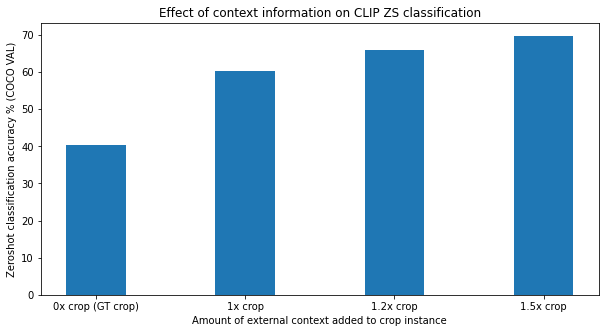

In [889]:
crop_information = ['0x crop (GT crop)', '1x crop', '1.2x crop', '1.5x crop']
classification_acc = [40.44, 60.21, 65.86, 69.77]
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.xlabel("Amount of external context added to crop instance")
plt.ylabel("Zeroshot classification accuracy % (COCO VAL)")
plt.title("Effect of context information on CLIP ZS classification")
plt.bar(crop_information, classification_acc,
        width = 0.4)
